# Maximum Likelihood Estimation

In [47]:
import pandas as pd
import numpy as np  
import csv
from scipy.optimize import minimize  

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from itertools import permutations

import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
df = pd.read_csv("final_data1.csv")
df

,constructorId,constructor_name,constructorStandingsId,raceId,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,FastLap_Rate,Points_Per_Entry,Years_Active,Champion,driverRef,code,driverStandingsId,points,position,driver_wins
0,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,0.064067,5.782730,19,True,alonso,ALO,68613,10.0,5,0
1,3,Williams,26940.0,989.0,8.0,0.0,15647.0,0.0,1,1,...,0.000000,1.629032,6,False,stroll,STR,68622,0.0,14,0
2,4,Renault,26937.0,989.0,5.0,0.0,15644.0,7.0,1,1,...,0.010811,2.816216,11,False,hulkenberg,HUL,68615,6.0,7,0
3,4,Renault,26937.0,989.0,5.0,0.0,15644.0,7.0,1,1,...,0.018293,4.844512,8,False,sainz,SAI,68618,1.0,10,0
4,5,Toro Rosso,26941.0,989.0,9.0,0.0,15648.0,0.0,1,1,...,0.027523,3.064220,6,False,gasly,GAS,68626,0.0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,210,Haas F1 Team,28711.0,1120.0,10.0,0.0,16888.0,0.0,22,24,...,0.010811,2.816216,11,False,hulkenberg,HUL,72510,9.0,16,0
1765,210,Haas F1 Team,28711.0,1120.0,10.0,0.0,16888.0,0.0,22,24,...,0.013986,1.279720,8,False,kevin_magnussen,MAG,72508,3.0,19,0
1766,213,AlphaTauri,28710.0,1120.0,8.0,0.0,16885.0,4.0,22,24,...,0.000000,0.977778,2,False,tsunoda,TSU,72506,17.0,14,0
1767,214,Alpine F1 Team,28708.0,1120.0,6.0,0.0,16886.0,0.0,22,24,...,0.000000,3.250000,6,False,ocon,OCO,72513,58.0,12,0


In [49]:
missing_columns = df.columns[df.isna().any()]
print("Columns with missing or NaN values:")
print(missing_columns)

Columns with missing or NaN values:
Index(['AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'Championship Years'],
      dtype='object')


In [50]:
df.dropna(subset=missing_columns)

,constructorId,constructor_name,constructorStandingsId,raceId,constructor_pos,constructor_wins,constructorResultsId,constructor_points,round,circuitId,...,FastLap_Rate,Points_Per_Entry,Years_Active,Champion,driverRef,code,driverStandingsId,points,position,driver_wins
0,1,McLaren,26936.0,989.0,4.0,0.0,15643.0,12.0,1,1,...,0.064067,5.782730,19,True,alonso,ALO,68613,10.0,5,0
5,9,Red Bull,26935.0,989.0,3.0,0.0,15642.0,20.0,1,1,...,0.128049,12.417683,8,True,max_verstappen,VER,68614,8.0,6,0
9,131,Mercedes,26934.0,989.0,2.0,0.0,15641.0,22.0,1,1,...,0.196141,14.197749,16,True,hamilton,HAM,68610,18.0,2,0
12,1,McLaren,26976.0,990.0,3.0,0.0,15655.0,10.0,2,3,...,0.064067,5.782730,19,True,alonso,ALO,68693,16.0,4,0
17,9,Red Bull,26975.0,990.0,4.0,0.0,15659.0,0.0,2,3,...,0.128049,12.417683,8,True,max_verstappen,VER,68694,8.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,117,Aston Martin,28694.0,1119.0,5.0,0.0,16873.0,12.0,21,80,...,0.064067,5.782730,19,True,alonso,ALO,72476,200.0,5,0
1744,131,Mercedes,28696.0,1119.0,2.0,0.0,16874.0,10.0,21,80,...,0.196141,14.197749,16,True,hamilton,HAM,72478,232.0,3,0
1757,9,Red Bull,28703.0,1120.0,1.0,21.0,16880.0,38.0,22,24,...,0.128049,12.417683,8,True,max_verstappen,VER,72496,575.0,1,19
1760,117,Aston Martin,28704.0,1120.0,5.0,0.0,16884.0,7.0,22,24,...,0.064067,5.782730,19,True,alonso,ALO,72498,206.0,4,0


In [51]:
missing_columns = df.columns[df.isna().any()]
print("Columns with missing or NaN values:")
print(missing_columns)

Columns with missing or NaN values:
Index(['AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'Championship Years'],
      dtype='object')


## Predicting the probability that drivers will place in the top 3

Preparing the data: Perform binary classification for whether a driver/constructor duo has placed in the top 3

In [52]:
df['results_pos'] = pd.to_numeric(df['results_pos'], errors='coerce')
df = df.fillna(22)
df['results_pos'] = df['results_pos'].astype(int)
df['top_3'] = (df['results_pos'] < 4)
df['top_3'] = df['results_pos'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

Preparing the data: Drop rows with missing position or needed features

In [53]:
df = df.dropna(subset=['position', 'constructorId', 'driverId'])

### Making the predictions with MLE (initial model)

In [54]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins','FastLap_Rate'
]
# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [55]:
# Train Logistic Regression (MLE under the hood)
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)
model.fit(X_train, y_train)


c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [56]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [57]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9532163742690059
Precision: 0.8405797101449275
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       279
           1       0.84      0.92      0.88        63

    accuracy                           0.95       342
   macro avg       0.91      0.94      0.92       342
weighted avg       0.96      0.95      0.95       342



## MLE Predictions

In [58]:
#Putting predictions in the dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_winner']= y_probs
constructor_winners['predicted_winner_probability']= y_pred

In [59]:
#get the names of all the races
unique_race_names = df['race_name'].unique()
print(unique_race_names)

['Australian Grand Prix' 'Bahrain Grand Prix' 'Chinese Grand Prix'
 'Azerbaijan Grand Prix' 'Spanish Grand Prix' 'Monaco Grand Prix'
 'Canadian Grand Prix' 'French Grand Prix' 'Austrian Grand Prix'
 'British Grand Prix' 'German Grand Prix' 'Hungarian Grand Prix'
 'Belgian Grand Prix' 'Italian Grand Prix' 'Singapore Grand Prix'
 'Russian Grand Prix' 'Japanese Grand Prix' 'United States Grand Prix'
 'Mexican Grand Prix' 'Brazilian Grand Prix' 'Abu Dhabi Grand Prix'
 'Styrian Grand Prix' '70th Anniversary Grand Prix' 'Tuscan Grand Prix'
 'Eifel Grand Prix' 'Portuguese Grand Prix' 'Emilia Romagna Grand Prix'
 'Turkish Grand Prix' 'Sakhir Grand Prix' 'Qatar Grand Prix'
 'Dutch Grand Prix' 'Mexico City Grand Prix' 'São Paulo Grand Prix'
 'Saudi Arabian Grand Prix' 'Miami Grand Prix' 'Las Vegas Grand Prix']


In [60]:
def get_prediction(race_name):
        filtered= constructor_winners[constructor_winners['race_name'] == race_name]
        
        if len(filtered) == 0:
            return f"No data for race: {race_name}"

        filtered= filtered.drop_duplicates(subset=['driverId'])
        
        return filtered.sort_values('predicted_winner_probability', ascending=False)

In [61]:
country= "Bahrain"
race= f"{country} Grand Prix"
race_pred= get_prediction(race)

# print(f"\nPredictions for {race}:")
# print(race_pred[['forename', 'surname', 'predicted_winner_probability']].head(10))

#looked online for how to make it look nicer
print(f"\n--- Predictions for {race} ---")
print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
print("-" * 50)

for i, (_, row) in enumerate(race_pred.head(3).iterrows(), 1):
    driver_name = f"{row['forename']} {row['surname']}"
    probability = f"{row['predicted_winner_probability']*100:.2f}%"
    print(f"{i:<8} {driver_name:<25} {probability:<15}")

#no lie i stole this code just so it looks nice. Please dont judge me -Saeed
# don't worry its been a long semester and same. have my model and just following your process - Zidane


--- Predictions for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Max Verstappen            100.00%        
2        Alexander Albon           100.00%        
3        Lewis Hamilton            100.00%        


From this we can see the results are a bit off so

Let's try to fix the model with varying features used and determining the best hyperparamters

In [62]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'laps', 'results_points', 'fastestLapSpeed',  #race and performance info
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',  #weather/track conditions
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums', #rest is for driver performance
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active'
]

# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Convert any non-numeric columns in feature_cols to numeric, coerce errors to NaN, then drop rows with NaN
for col in feature_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.dropna()
y = y.loc[X.index]
groups = groups.loc[X.index]

# Redefine train/test split after cleaning
train_idx, test_idx = next(split.split(X, y, groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



C:\Users\zidti\AppData\Local\Temp\ipykernel_21848\1695881578.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


In [63]:
# Train Logistic Regression (MLE under the hood)
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)
model.fit(X_train, y_train)


c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [64]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [65]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9969788519637462
Precision: 0.984375
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       0.98      1.00      0.99        63

    accuracy                           1.00       331
   macro avg       0.99      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331



Our model is a bit overfitted, let's chage paramters again

In [66]:
model = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced')
model.fit(X_train, y_train)

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [67]:
# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

In [68]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9818731117824774
Precision: 0.9130434782608695
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       268
           1       0.91      1.00      0.95        63

    accuracy                           0.98       331
   macro avg       0.96      0.99      0.97       331
weighted avg       0.98      0.98      0.98       331



This is slightly better but it's still too perfect

### Finding the best parameters and regularization methods

In [69]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000),
                           param_grid,
                           cv=5,
                           scoring='f1')  # or 'roc_auc' if class imbalance
grid_search.fit(X_train, y_train)

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='f1')

Using the GridSearchCV given best and making sure class_weights are balanced

In [70]:
model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluation
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9969788519637462
Precision: 0.984375
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       0.98      1.00      0.99        63

    accuracy                           1.00       331
   macro avg       0.99      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331



In [71]:
# Drop rows with missing target
df = df.dropna(subset=['position'])

# Define top-3 label
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['top_3'] = df['position'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Define features
feature_cols = [
    'grid', 'laps', 'results_points',  # removed post race data which may have making the data assess on metrics would not have been available during an actual race
    'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'Race_Entries', 'Race_Starts', 'Pole_Positions', 'Race_Wins', 'Podiums',
    'Fastest_Laps', 'Points', 'Pole_Rate', 'Start_Rate', 'Win_Rate', 'Podium_Rate',
    'FastLap_Rate', 'Points_Per_Entry', 'Years_Active'
]

# Drop rows with missing feature values
df = df.dropna(subset=feature_cols)

# Extract features and target
X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
y = df['top_3'].astype(int)
groups = df['raceId']  # Group by race

# Final NaN handling
valid_idx = X.dropna().index
X, y, groups = X.loc[valid_idx], y.loc[valid_idx], groups.loc[valid_idx]

# Train-test split using GroupShuffleSplit (group by race)
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Logistic Regression (MLE-style) with balanced class weights
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000, class_weight='balanced', solver='lbfgs')
model.fit(X_train, y_train)

# Prediction
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8713450292397661
Precision: 0.59
ROC AUC: 0.9540322580645162
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       280
           1       0.59      0.95      0.73        62

    accuracy                           0.87       342
   macro avg       0.79      0.90      0.82       342
weighted avg       0.92      0.87      0.88       342



Unforutnately the model appears to be Overfitted. Let's see what we can do to alleviate that

This is used to check if there is Duplicate or Overlapping Data in Train/Test. A non-empty set will give that it is

In [72]:
print(set(groups.iloc[train_idx]) & set(groups.iloc[test_idx]))

set()


Getting the top 3 likelihoods given the race name, dataframe, model and features selected

In [73]:
def get_top_3_predictions(race_name, full_df, model_pipeline, feature_cols):
    race_df = full_df[full_df['race_name'] == race_name].copy()
    race_df = race_df.dropna(subset=feature_cols)
    race_features = race_df[feature_cols].apply(pd.to_numeric, errors='coerce').dropna()

    if race_features.empty:
        print(f"No valid feature data for race: {race_name}")
        return

    race_df = race_df.loc[race_features.index]
    race_probs = model_pipeline.predict_proba(race_features)[:, 1]
    race_df['win_probability'] = race_probs

    top3 = race_df.sort_values('win_probability', ascending=False).head(3)
    print(f"\n--- Predicted Top 3 for {race_name} ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        driver_name = f"{row['forename']} {row['surname']}"
        probability = f"{row['win_probability']*100:.2f}%"
        print(f"{i:<8} {driver_name:<25} {probability:<15}")


In [74]:
# puting predictions to dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_proba'] = y_probs

In [75]:
# top-3 prediction for Bahrain Grand Prix
get_top_3_predictions("Bahrain Grand Prix", constructor_winners, model, feature_cols)


--- Predicted Top 3 for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Lewis Hamilton            98.99%         
2        Max Verstappen            97.72%         
3        Valtteri Bottas           71.22%         


These result gave the most favourable and least suspicious results when determining performance, however we need to discuss the output of predictions. Additionally we stll want to get the best hyperparameters for these results and as such use the one from the grid search suggestion.

In [76]:
# useful features for making top 3 predictions
feature_cols = [ # determined essential feature for making constructor x driver predictions
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins','FastLap_Rate'
]
# check existing columns else drop
df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['top_3']
groups = df['raceId']  # group by race

# group-aware train-test split
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Logistic Regression (MLE-style) with balanced class weights
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000, class_weight='balanced', solver='lbfgs')
model.fit(X_train, y_train)

# Prediction
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.5).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

Accuracy: 0.9035087719298246
Precision: 0.6705882352941176
ROC AUC: 0.9767569124423963
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       280
           1       0.67      0.92      0.78        62

    accuracy                           0.90       342
   macro avg       0.83      0.91      0.86       342
weighted avg       0.92      0.90      0.91       342



c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This model looks a lot better lets see what output it gives and ensure that there's nothing wrong with it

Recall: This is used to check if there is Duplicate or Overlapping Data in Train/Test

In [77]:
print(set(groups.iloc[train_idx]) & set(groups.iloc[test_idx]))

set()


Preparing to make predictions

In [78]:
# puting predictions to dataframe
constructor_winners = df.loc[X_test.index].copy()
constructor_winners['predicted_proba'] = y_probs

In [79]:
# Top-3 prediction for Bahrain Grand Prix
get_top_3_predictions("Bahrain Grand Prix", constructor_winners, model, feature_cols)


--- Predicted Top 3 for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Lewis Hamilton            100.00%        
2        Valtteri Bottas           98.55%         
3        Max Verstappen            93.22%         


## Swap to K-fold

While the results seem deceptively good, after reviewing with pairs there appears to be an issue with both the predicted positions of drivers and the win probability

Another method for making predictions. In this we replace GroupShuffleSplit with StratifiedGroupKFold

Using the Stratified Group K Fold we can ensure that each group will appear exactly once in the test set across all folds (the number of distinct groups has to be at least equal to the number of folds).

In [80]:
# Label target and features
df['top_3'] = df['position'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Only use the selected features
feature_cols = [
    'grid', 'constructor_points', 'constructor_wins', 'Pole_Rate', 'Win_Rate', 
    'Points_Per_Entry', 'Years_Active', 'Race_Wins', 'Fastest_Laps',
    'Podium_Rate', 'Points', 'Start_Rate', 'driver_wins', 'FastLap_Rate'
]

df = df.dropna(subset=feature_cols + ['raceId', 'position'])
X = df[feature_cols]
y = df['top_3']
groups = df['raceId']

# Convert features to numeric
for col in feature_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.dropna()
y = y.loc[X.index]
groups = groups.loc[X.index]

# Model
model = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='lbfgs', max_iter=1000)

# Stratified Group K-Fold
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
all_y_true = []
all_y_probs = []

for train_idx, test_idx in cv.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]

    all_y_true.extend(y_test)
    all_y_probs.extend(y_probs)

# Metrics
all_y_true = np.array(all_y_true)
all_y_pred = (np.array(all_y_probs) > 0.5).astype(int)

print("Accuracy:", accuracy_score(all_y_true, all_y_pred))
print("Precision:", precision_score(all_y_true, all_y_pred))
print("Recall:", recall_score(all_y_true, all_y_pred))
print("F1 Score:", f1_score(all_y_true, all_y_pred))
print("ROC AUC:", roc_auc_score(all_y_true, all_y_probs))
print("Log Loss:", log_loss(all_y_true, all_y_probs))
print(classification_report(all_y_true, all_y_pred))

C:\Users\zidti\AppData\Local\Temp\ipykernel_21848\2651484171.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465

Accuracy: 0.92312040700961
Precision: 0.7357142857142858
Recall: 0.9251497005988024
F1 Score: 0.8196286472148541
ROC AUC: 0.9762304658974733
Log Loss: 0.19902413753821172
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1435
           1       0.74      0.93      0.82       334

    accuracy                           0.92      1769
   macro avg       0.86      0.92      0.89      1769
weighted avg       0.94      0.92      0.93      1769



c:\Users\zidti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature Importance

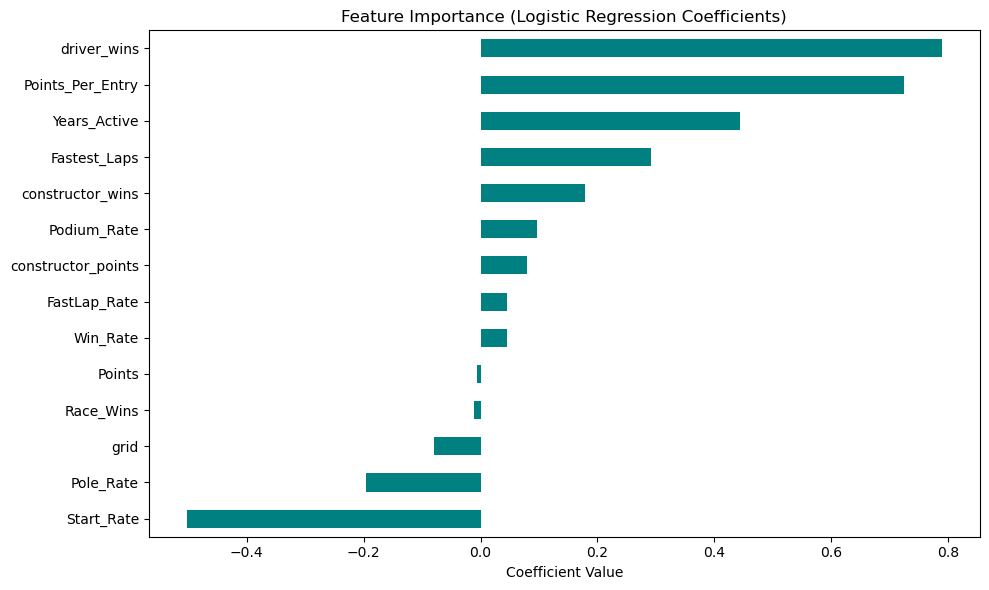

In [81]:
coefs = pd.Series(model.coef_[0], index=feature_cols).sort_values()

plt.figure(figsize=(10, 6))
coefs.plot(kind='barh', color='teal')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


Class Distributions

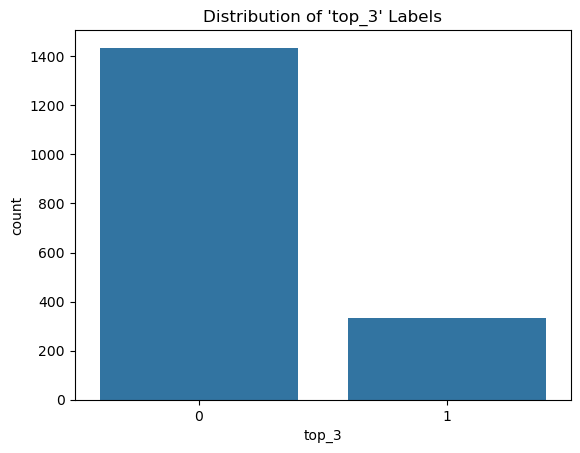

In [82]:
sns.countplot(data=df, x='top_3')
plt.title("Distribution of 'top_3' Labels")
plt.show()


Predicted Probability Confidence

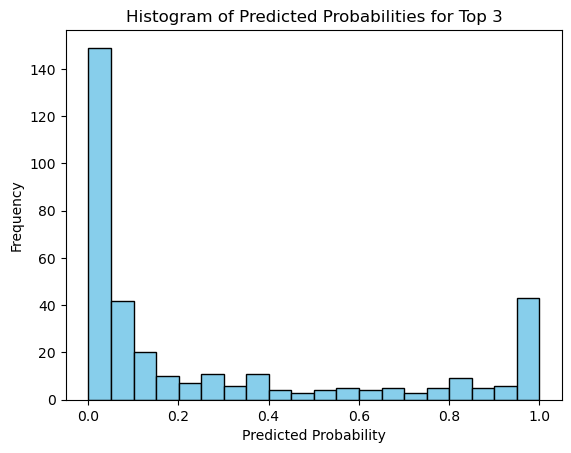

In [83]:
plt.hist(y_probs, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Predicted Probabilities for Top 3")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


This shows that the model presently is either 100% certain of its results of the time or is completetly uncertain  

Visualization

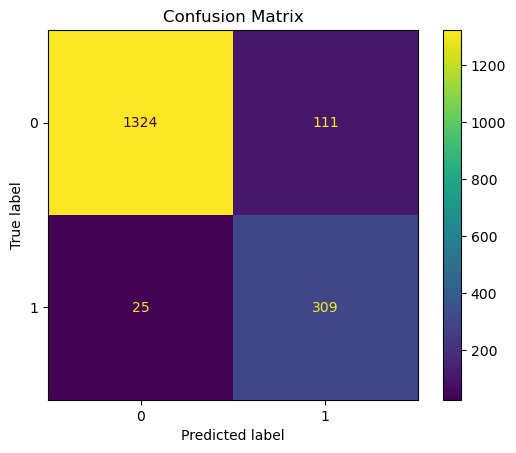

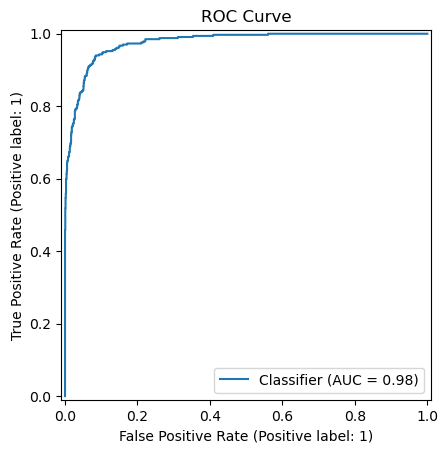

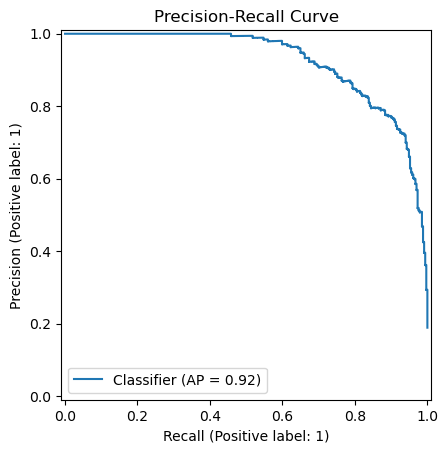

In [84]:
# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(all_y_true, all_y_probs)
plt.title("ROC Curve")
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(all_y_true, all_y_probs)
plt.title("Precision-Recall Curve")
plt.show()

Redoing the get top 3 predictions

In [85]:
def get_top_3_predictions(race_name, full_df, model_pipeline, feature_cols):
    race_df = full_df[full_df['race_name'] == race_name].copy()
    race_df = race_df.dropna(subset=feature_cols)
    race_features = race_df[feature_cols].apply(pd.to_numeric, errors='coerce').dropna()

    if race_features.empty:
        print(f"No valid feature data for race: {race_name}")
        return

    race_df = race_df.loc[race_features.index]
    race_probs = model_pipeline.predict_proba(race_features)[:, 1]
    race_df['win_probability'] = race_probs

    # Create full driver name and ensure uniqueness
    race_df['driver_name'] = race_df['forename'] + ' ' + race_df['surname']
    race_df = race_df.drop_duplicates(subset='driver_name', keep='first')

    # Get top 3 unique drivers by probability
    top3 = race_df.sort_values('win_probability', ascending=False).head(3)

    print(f"\n--- Predicted Top 3 for {race_name} ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        print(f"{i:<8} {row['driver_name']:<25} {row['win_probability']*100:.2f}%")


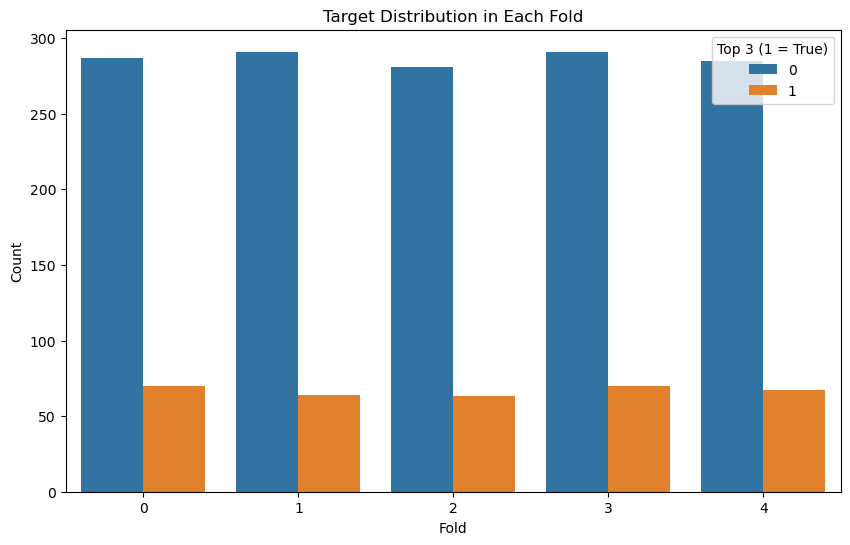

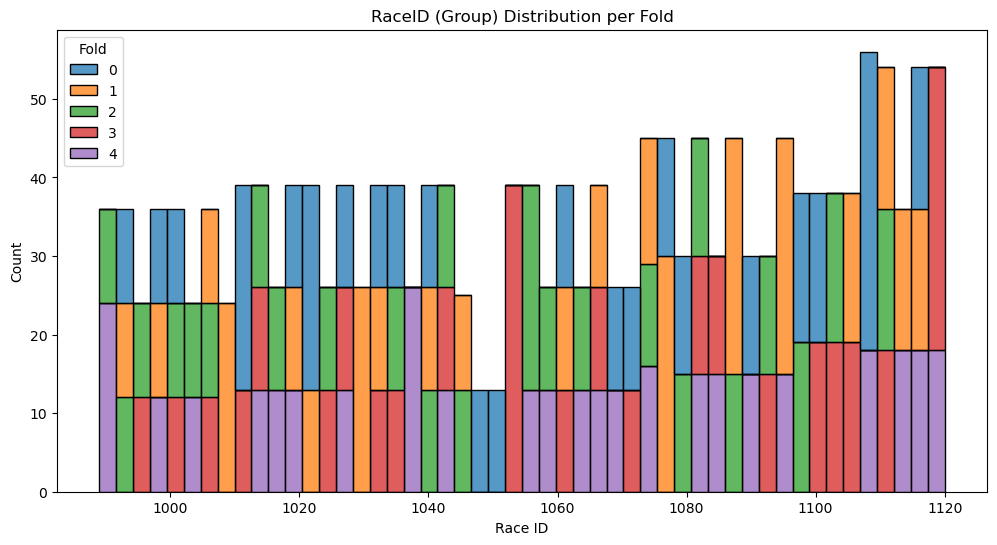

In [86]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

fold_data = []

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
    for idx in test_idx:
        fold_data.append({
            "Index": idx,
            "RaceID": groups.iloc[idx],
            "Target": y.iloc[idx],
            "Fold": fold_idx
        })

fold_df = pd.DataFrame(fold_data)

# Sort for better visualization
fold_df = fold_df.sort_values(by=["Fold", "RaceID"])

# Plot distribution of top_3 (target) per fold
plt.figure(figsize=(10, 6))
sns.countplot(data=fold_df, x="Fold", hue="Target")
plt.title("Target Distribution in Each Fold")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.legend(title="Top 3 (1 = True)")
plt.show()

# Optional: Visualize group (raceId_x) allocation per fold
plt.figure(figsize=(12, 6))
sns.histplot(data=fold_df, x="RaceID", hue="Fold", bins=50, palette="tab10", multiple="stack")
plt.title("RaceID (Group) Distribution per Fold")
plt.xlabel("Race ID")
plt.ylabel("Count")
plt.show()


In [87]:
get_top_3_predictions("Bahrain Grand Prix", df, model, feature_cols)


--- Predicted Top 3 for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Lewis Hamilton            80.85%
2        Valtteri Bottas           70.32%
3        Fernando Alonso           29.54%


There is still an issue with how the win probability is done. At present the probability is determined by: sorting the drivers by their win probability in descending order and selecting the top three. This new version of the function does the probabilities of winning in a distributed manner.

In [88]:
def get_top_3_predictions(race_name, full_df, model, feature_cols):
    race_df = full_df[full_df['race_name'] == race_name].copy()
    race_df = race_df.dropna(subset=feature_cols)
    race_features = race_df[feature_cols].apply(pd.to_numeric, errors='coerce').dropna()

    if race_features.empty:
        print(f"No valid feature data for race: {race_name}")
        return

    race_df = race_df.loc[race_features.index]

    # Predict raw probabilities
    raw_probs = model.predict_proba(race_features)[:, 1]

    # Normalize probabilities to sum to 1
    normalized_probs = raw_probs / raw_probs.sum()
    race_df['win_probability'] = normalized_probs

    # Deduplicate by driver name (assumes uniqueness by full name or driverId)
    race_df['driver_name'] = race_df['forename'] + ' ' + race_df['surname']
    race_df = race_df.drop_duplicates(subset='driver_name')

    # Get top 3
    top3 = race_df.sort_values('win_probability', ascending=False).head(3)

    print(f"\n--- Predicted Top 3 for {race_name} ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        print(f"{i:<8} {row['driver_name']:<25} {row['win_probability']*100:.2f}%")


In [89]:
get_top_3_predictions("Bahrain Grand Prix", df, model, feature_cols)


--- Predicted Top 3 for Bahrain Grand Prix ---
Position Driver                    Win Probability
--------------------------------------------------
1        Lewis Hamilton            3.98%
2        Valtteri Bottas           3.46%
3        Fernando Alonso           1.45%


Getting the possible top 3 drivers in order (a permutation)

In [90]:
def get_top_3_predictions(race_name, full_df, model, feature_cols, plot=True, top_k_combos=10):
    race_df = full_df[full_df['race_name'] == race_name].copy()
    race_df = race_df.dropna(subset=feature_cols)
    race_features = race_df[feature_cols].apply(pd.to_numeric, errors='coerce').dropna()

    if race_features.empty:
        print(f"No valid feature data for race: {race_name}")
        return

    race_df = race_df.loc[race_features.index]

    # Predict and normalize
    raw_probs = model.predict_proba(race_features)[:, 1]
    normalized_probs = raw_probs / raw_probs.sum()
    race_df['win_probability'] = normalized_probs

    # Create driver names
    race_df['driver_name'] = race_df['forename'] + ' ' + race_df['surname']

    # --- Top-3 Permutations ---
    driver_probs = race_df.set_index('driver_name')['win_probability'].to_dict()
    all_perms = list(permutations(driver_probs.keys(), 3))

    # Score each permutation: simple product of their probs (could be improved with joint modeling)
    perm_scores = []
    for perm in all_perms:
        score = driver_probs[perm[0]] * driver_probs[perm[1]] * driver_probs[perm[2]]
        perm_scores.append((perm, score))

    # Get top-K permutations
    top_perms = sorted(perm_scores, key=lambda x: x[1], reverse=True)[:top_k_combos]

    # Print top combinations
    print(f"\n--- Top {top_k_combos} Most Likely Podium Combos for {race_name} ---")
    for i, (combo, score) in enumerate(top_perms, 1):
        formatted_combo = " > ".join(combo)
        print(f"{i:<3} {formatted_combo:<60} Likelihood Score: {score:.6f}")

    # Print top 3 by single-driver probability
    top3 = race_df.sort_values('win_probability', ascending=False).head(3)
    print(f"\n--- Top 3 Individual Probabilities ---")
    print(f"{'Position':<8} {'Driver':<25} {'Win Probability':<15}")
    print("-" * 50)
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        driver_name = row['driver_name']
        probability = f"{row['win_probability']*100:.2f}%"
        print(f"{i:<8} {driver_name:<25} {probability:<15}")

    # Plot if enabled
    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=race_df.sort_values('win_probability', ascending=False),
            x='win_probability',
            y='driver_name',
            palette='magma'
        )
        plt.title(f"Normalized Win Probabilities - {race_name}")
        plt.xlabel("Probability")
        plt.ylabel("Driver")
        plt.tight_layout()
        plt.show()

    return race_df.sort_values('win_probability', ascending=False)



--- Top 10 Most Likely Podium Combos for Bahrain Grand Prix ---
1   Lewis Hamilton > Valtteri Bottas > Max Verstappen            Likelihood Score: 0.017524
2   Valtteri Bottas > Lewis Hamilton > Max Verstappen            Likelihood Score: 0.017524
3   Max Verstappen > Lewis Hamilton > Valtteri Bottas            Likelihood Score: 0.017524
4   Max Verstappen > Valtteri Bottas > Lewis Hamilton            Likelihood Score: 0.017524
5   Lewis Hamilton > Max Verstappen > Valtteri Bottas            Likelihood Score: 0.017524
6   Valtteri Bottas > Max Verstappen > Lewis Hamilton            Likelihood Score: 0.017524
7   Lando Norris > Valtteri Bottas > Lewis Hamilton              Likelihood Score: 0.004624
8   Lewis Hamilton > Valtteri Bottas > Lando Norris              Likelihood Score: 0.004624
9   Valtteri Bottas > Lando Norris > Lewis Hamilton              Likelihood Score: 0.004624
10  Valtteri Bottas > Lewis Hamilton > Lando Norris              Likelihood Score: 0.004624

--- Top 3 Indi

C:\Users\zidti\AppData\Local\Temp\ipykernel_21848\2010599486.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


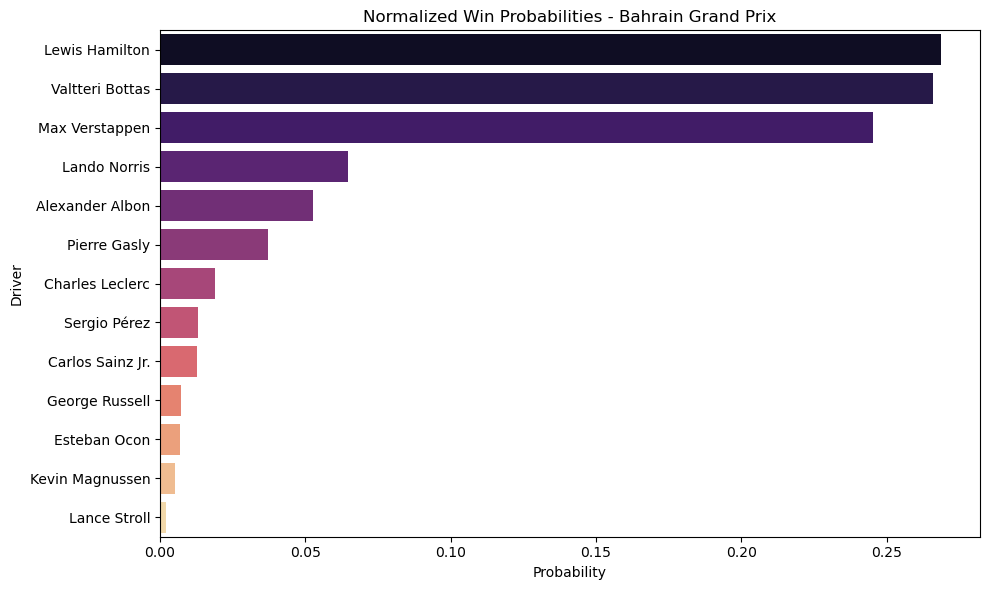

In [91]:
bahrain_results = get_top_3_predictions(
    "Bahrain Grand Prix", constructor_winners, model, feature_cols, plot=True, top_k_combos=10
)


Normally Verstappen would likely take first but as this is being done by position and likelihood according to the top 3 for 2018-2023 results it appears in this order